# Reading and visualizing a NetCDF file with SURFRAD solar radiation data

*Date: April 29th, 2020*

## Overview
This tutorial will demonstrate how to open and manipulate a NetCDF file from a thredds data server, containing solar radiation data from the BSRN network.

NetCDF is a file format for storing array oriented scientific data, such as solar radiation, temperature or aerosol optical depth. The format has a number of advantages over other common file formats, including the standardized integration of metadata allowing for the data to be self-describin and easy access of a subset of a larger dataset.

## Source data
The data in this tutorial is from the SURFRAD (https://gml.noaa.gov/grad/surfrad/), which is an American network of high quality stations measuring solar and atmospheric radiation. Currently, there are 7 stations in operation, measuring at a minimum: global horizontal irradiance, diffuse horizontal irradiance and direct normal irradiance with a 1 minute time step.

SURFRAD and other data are available as NetCDF files on a thredds server hosted at [webservice-energy.org](http://webservice-energy.org). The naming conventions follow the [climate and forecast conventions](https://www.unidata.ucar.edu/software/netcdf/conventions.html) in order to be interoperable. 

# Import python modules
***
First import the necessary modules:

In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4 as nc
import datetime as dt
import pandas as pd
import numpy as np
import sg2
import sys
from datetime import datetime, timedelta
from IPython import display
from lib.utils import *

# Visualisation of the content of the TDS server

Check the content of the catalog at the following URL :

[http://tds.webservice-energy.org/thredds/catalog/surfrad-stations/catalog.html](http://tds.webservice-energy.org/thredds/catalog/surfrad-stations/catalog.html)

# Read NetCDF file

Here, we access data from the SURFRAD station "Bondville" from the thredds server.


## Option 1) Manually

The first option is to use the NetCDF libary to access the data over the OpenDAP protocol :

In [2]:
# URL of the NetCDF file on a Thredds server, accessed via OpenDAP
url = 'http://tds.webservice-energy.org/thredds/dodsC/surfrad-stations/SURFRAD-BON.nc'

# Open the NetCDF file from the server (without downloading the data yet)
data_nc = nc.Dataset("[FillMismatch]"+url) 

# Show the meta data :
print(data_nc)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    description: Archive of solar radiation networks worldwide provided by the Webservice-Energy initiative supported by MINES Paris PSL. Files are provided as NetCDF file format with the support of a Thredds Data Server.
    title: Timeseries of NOAA's Surface Radiation Budget Network (SURFRAD) (SURFRAD)
    keywords: meteorology, station, time, Earth Science > Atmosphere > Atmospheric Radiation > Incoming Solar Radiation, Earth Science > Atmosphere > Atmospheric Temperature > Surface Temperature > Air Temperature, Earth Science > Atmosphere > Atmospheric Pressure > Sea Level Pressure
    keywords_vocabulary: GCMD Science Keywords
    keywords_vocabulary_url: https://gcmd.earthdata.nasa.gov/static/kms/
    contact: Lionel MENARD, Raphael JOLIVET, Yves-Marie SAINT-DRENAN, Philippe BLANC
    institution:  MINES Paris PSL
    record: Basic measurements (global irradiance, direct irradiance, diff



The NetCDF file contains several variables:

In [3]:
data_nc.variables.keys()

dict_keys(['station_name', 'latitude', 'longitude', 'elevation', 'Time', 'GHI', 'DHI', 'BNI', 'T2', 'WS', 'WD'])

<br>
Each variable contains metadata describing the variable. For example, for the variable GHI, the metadata gives the fullname (Global Horizontal Irradiance), the unit (W/m$^2$) and gives a comment that "GHI is set to 0 for SZA >= 97 deg".

In [4]:
data_nc.variables['GHI']

<class 'netCDF4._netCDF4.Variable'>
float32 GHI(time)
    parameter: Short-wave downward (GLOBAL) radiation
    long_name: Global Horizontal Irradiance
    standard_name: surface_downwelling_shortwave_flux_in_air
    abbreviation: SWD
    units: W m-2
    Range_LowerBoundary: -10.0
    Range_UpperBoundary: 3000
    Description: global, mean
    least_significant_digit: 1
    FirstData: 1997-05-11T00:00
    LastData: 2022-02-27T23:59
    _ChunkSizes: 1024
unlimited dimensions: time
current shape = (14284800,)
filling off

<br>

Furthermore, this dataset contains three variables related to the location of the BSRN station: latitude, longitude and elevation.

In [5]:
lat  = data_nc.variables['latitude'][:]
lon  = data_nc.variables['longitude'][:]
elev = data_nc.variables['elevation'][:]
print("Latitude = %s° N" % lat)
print("Longitude = %s° E" % lon) 
print("Elevation = %sm" % elev)

Latitude = 40.05° N
Longitude = -88.37° E
Elevation = 213.0m


<br>
Next, the time series data is extracted and saved to individual variables. 
For demonstration purposes, only measurement data for the first three years are extracted.

In [6]:
%%time

NB_SAMPLES=60*24*365*3 # 3 years of data

# Loading and convert the time vector 
time=pd.to_datetime(
    data_nc.variables['Time'][-NB_SAMPLES:], unit='s', origin=pd.Timestamp('1970-01-01'))

# Download measurements of the three components of the solar irradiance
GHI = data_nc.variables['GHI'][-NB_SAMPLES:].filled(np.nan)
DHI = data_nc.variables['DHI'][-NB_SAMPLES:].filled(np.nan)
BNI = data_nc.variables['BNI'][-NB_SAMPLES:].filled(np.nan)

# Build a Pandas Dataframe
data = pd.DataFrame({'GHI': GHI,'BNI': BNI,'DHI':DHI}, index=time)

# Show first values
data.head()

CPU times: user 9.54 s, sys: 82.7 ms, total: 9.62 s
Wall time: 10.3 s


,GHI,BNI,DHI
2019-03-01 00:00:00,-1.3,0.4,0.1
2019-03-01 00:01:00,-1.3,0.4,-0.2
2019-03-01 00:02:00,-1.3,0.4,-0.3
2019-03-01 00:03:00,-1.3,0.4,-0.4
2019-03-01 00:04:00,-1.3,0.4,-0.4


## Option 2) Use `libinsitu`

We developped [libinsitu](https://git.sophia.mines-paristech.fr/oie/libinsitu), a library providing several utils to read and manipulate NetCDF files for in situ data.

This library provides the function [`nc2df()`](https://git.sophia.mines-paristech.fr/oie/libinsitu#nc2df) that automize all the steps above to read NetCDF data into a Panda Dataframe :

In [7]:
from libinsitu.common import nc2df

start = datetime.now() - timedelta(days=365*3)

# Load data over OpenDAP into a pandas DataFrame
# 'url' is defined in the section above 
data = nc2df(url, vars=["GHI", "DHI", "BNI"], start_time=start, drop_duplicates=True)

In [8]:
# Meta data is attached to the resulting dataframe
print(data.attrs)

# libinsitu took care of transforming the time series, replacing missing vals by Nans
print(data.head())

{'description': 'Archive of solar radiation networks worldwide provided by the Webservice-Energy initiative supported by MINES Paris PSL. Files are provided as NetCDF file format with the support of a Thredds Data Server.', 'title': "Timeseries of NOAA's Surface Radiation Budget Network (SURFRAD) (SURFRAD)", 'keywords': 'meteorology, station, time, Earth Science > Atmosphere > Atmospheric Radiation > Incoming Solar Radiation, Earth Science > Atmosphere > Atmospheric Temperature > Surface Temperature > Air Temperature, Earth Science > Atmosphere > Atmospheric Pressure > Sea Level Pressure', 'keywords_vocabulary': 'GCMD Science Keywords', 'keywords_vocabulary_url': 'https://gcmd.earthdata.nasa.gov/static/kms/', 'contact': 'Lionel MENARD, Raphael JOLIVET, Yves-Marie SAINT-DRENAN, Philippe BLANC', 'institution': ' MINES Paris PSL', 'record': 'Basic measurements (global irradiance, direct irradiance, diffuse irradiance, air temperature, relative humidity, pressure)', 'Network_ShortName': 'S

# 3: Calculation of sun position
***

In this tutorial, the sun position will be calculated using the wps_SG2 webservice available through the python package *solargeometry*. A request is sent to the webservice, which carries out the calculations and returns the results. For longer time series, this method is significantly faster than calculating the sun position locally using, for example, the pvlib-python library.


output
    The output is a python list of fields identified by python strings.  Each
    given fields will be computed and provided in the output o as follow :
    *"field.name"* will be *o.field.name*.  Possible fields and there output
    type are:

    * "geoc.ut" **timestamp** as array of datetime64[ms]
    * "geoc.tt" **terrestrial time** as array of datetime64[ms]
    * "geoc.R" **Radius Sun-Earth** in astronomical unit (au) as array of double
    * "geoc.L" **Heliocentric Earth true longitude** in radians as array of double
    * "geoc.delta" **Geocentric declination** in radians as array of double
    * "geoc.EOT" **Equation of Time: difference between apparent solar time and mean solar time** in radians as array of double (to be multiplied by pi/12 for hourly values)
    * "geoc.Theta_a" **Geocentric Earth true longitude** in radians as array of double
    * "geoc.epsilon" **Earth true obliquity** in radians as array of double
    * "geoc.nu" **Apparent sideral time** in radians as array of double
    * "geoc.r_alpha" **Geocentric right ascension** in radians as array of double
    * "geoc.Delta_psi" **Nutation in Geocentric Sun longitude** in radians as array of double
    * "gp.lambda" **Longitude** in radians as array of double
    * "gp.phi" **Latitude** in radians as array of double
    * "gp.u" **phi geocentric**
    * "gp.x"
    * "gp.y"
    * "topoc.delta" **Topocentric sun declination** in radians as array of double
    * "topoc.alpha_S" **Topocentric sun azimuth** in radians as array of double
    * "topoc.gamma_S0" **Topocentric sun elevation angle without correction of atm. refraction.** in radians as array of double
    * "topoc.omega" **Topocentric local hour angle** in radians as array of double
    * "topoc.r_alpha" **Topocentric right sun ascension** in radians as array of double
    * "topoc.toa_hi" **Top of atmosphere horizontal irradiance** in W.m^{-2} as array of double
    * "topoc.toa_ni" **Top of atmosphere normal irradiance** in W.m^{-2} as array of double

    The abreviations geoc and topoc stand for respectively geocentric and topocentric.

    Moreover the size of arrays of geoc.* fields will be (M,), the size of
    arrays of gp.* fields will be (N,) and the size of arrays of topoc.* will
    be (N,M).


This library can be installed via pip:  "pip install sg2 -f https://pip.oie-lab.net/python-devel/ "


In [9]:
gp = [lat, lon, elev]

p = sg2.sun_position([gp], data.index.values,
                     ["geoc.EOT",
                      "topoc.omega",
                      "topoc.gamma_S0",
                      "topoc.alpha_S",
                      "topoc.delta",
                      "topoc.r_alpha",
                      "topoc.toa_hi",
                      "topoc.toa_ni"])
print(p)

namespace(geoc=namespace(EOT=array([245.05889599, 245.0588962 , 245.05889642, ..., 263.83887605,
       263.8388766 , 263.83887715])), gp=namespace(), topoc=namespace(alpha_S=array([[4.17638793, 4.17200626, 4.16762444, ..., 2.51279869, 2.50844836,
        2.50409799]]), delta=array([[ 0.2896983 ,  0.28970169,  0.28970508, ..., -0.1405939 ,
        -0.14058932, -0.14058475]]), gamma_S0=array([[-0.30431925, -0.30442921, -0.30453889, ...,  0.11760394,
         0.11767259,  0.11774168]]), omega=array([[90542.81454369, 90542.81890723, 90542.82327076, ...,
        97022.43689043, 97022.4412543 , 97022.44561817]]), r_alpha=array([[ 0.75810646,  0.75811819,  0.75812993, ..., -0.33265966,
        -0.33264826, -0.33263686]]), toa_hi=array([[  0.        ,   0.        ,   0.        , ..., 162.89569924,
        162.99029448, 163.08548908]]), toa_ni=array([[   0.        ,    0.        ,    0.        , ..., 1388.31912959,
        1388.31865731, 1388.31818502]])))


Computation of sun rise and sunset with `sg2`.


def sun_rise(ggeopoint, timestamp)
- input geopoints: (N,3) of double each row is lon in degrees, lat in degrees, altitude in metter.
  - input timespamp: (M,) of double or datetime64. the requested timestamp in ut
  - output: (N,M,3) datetime64[ms] with repectively sun rise, sun transit and
sun set in ut.

In [10]:
SR=sg2.sun_rise([gp], data.index.values)
print(SR.shape)

(1480719, 1, 3)


# Merge and save data

The final step is to combine the measurement time series and the sun position time series into one Pandas DataFrame.

In [11]:
out = pd.DataFrame({'GHI': data.GHI,
                   'BNI': data.BNI,
                   'DHI': data.DHI,
                   'DELTA':np.squeeze(p.topoc.delta),
                   'OMEGA':np.squeeze(p.topoc.omega),
                   'EOT':np.squeeze(p.geoc.EOT),
                   'THETA_Z':np.squeeze(np.pi/2-p.topoc.gamma_S0),
                   'GAMMA_S0':np.squeeze(p.topoc.gamma_S0),
                   'ALPHA_S':np.squeeze(p.topoc.alpha_S),
                   'R':np.squeeze(p.topoc.r_alpha),
                   'TOA':np.squeeze(p.topoc.toa_hi),
                   'TOANI':np.squeeze(p.topoc.toa_ni),
                   'SR_h':SR[:,0,0],
                   'SS_h':SR[:,0,2],
                  }, index=data.index.values)
out.head()

,GHI,BNI,DHI,DELTA,OMEGA,EOT,THETA_Z,GAMMA_S0,ALPHA_S,R,TOA,TOANI,SR_h,SS_h
2019-05-06 17:21:00,644.500000,151.100006,490.100006,0.289698,90542.814544,245.058896,1.875116,-0.304319,4.176388,0.758106,0.0,0.0,NaT,NaT
2019-05-06 17:22:00,673.400024,182.800003,490.500000,0.289702,90542.818907,245.058896,1.875226,-0.304429,4.172006,0.758118,0.0,0.0,NaT,NaT
2019-05-06 17:23:00,NaN,138.199997,487.000000,0.289705,90542.823271,245.058896,1.875335,-0.304539,4.167624,0.758130,0.0,0.0,NaT,NaT
2019-05-06 17:24:00,NaN,107.000000,484.500000,0.289708,90542.827634,245.058897,1.875445,-0.304648,4.163242,0.758142,0.0,0.0,NaT,NaT
2019-05-06 17:25:00,675.799988,190.199997,487.399994,0.289712,90542.831998,245.058897,1.875554,-0.304757,4.158860,0.758153,0.0,0.0,NaT,NaT


In [12]:
# Copy meta data into merged dataframe
out.attrs = data.attrs

It is possible to save Dataframes into various formats.
Here we choose "Parquet" format. A compact and portable format :

In [13]:
# Save data to parquet file
print(TMP_FILE)
out.to_parquet(TMP_FILE)

# Save meta data to json file
print(META_FILE)
save_meta(out, META_FILE)

./tmpData/data.parquet
./tmpData/data.meta


# Plots

Once all the data is combined into one DataFrame, manipulation and plotting become relatively easy tasks.

## Raw time series

The first month of the GHI, DHI, and BNI is plotted with the original 1 minute resolution:

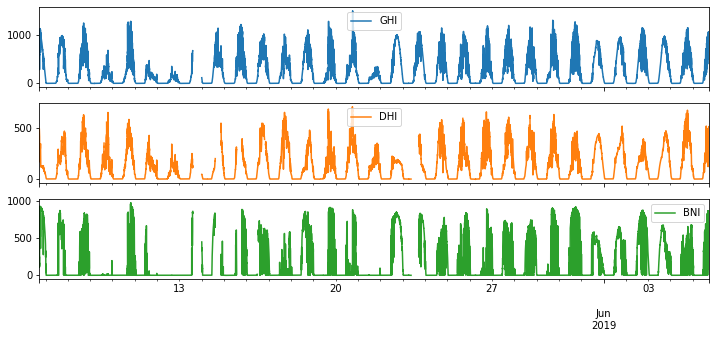

In [14]:
_ = out.iloc[0:30*60*24][["GHI", "DHI", "BNI"]].plot(figsize=(12,5), subplots=True)

## Monthly average

Here, we plot the monthly average irradiance as a bar chart, can be done in one line as well:

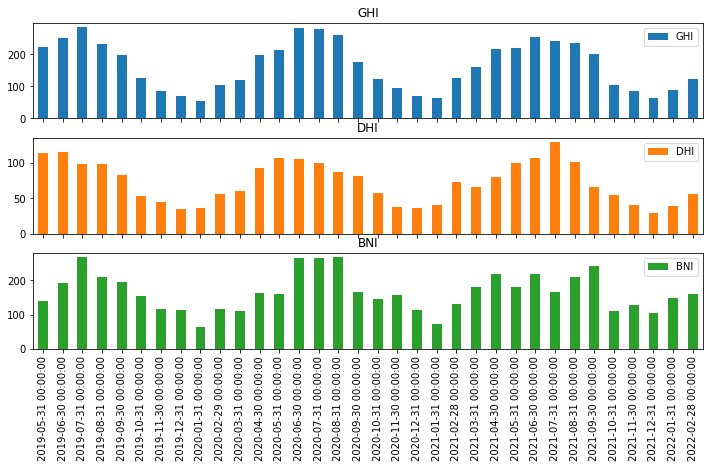

In [15]:
_ = out[['GHI','DHI','BNI']].resample('1M').mean().plot(figsize=(12,6), kind='bar', subplots=True)